## MarTech Challenge 用户购买预测思路整理（二分类）

In [7]:
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid",{"font.sans-serif":['simhei','Droid Sans Fallback']})
import numpy as np
import warnings #ignore warnings
warnings.filterwarnings("ignore")
raw = pd.read_csv('/home/guanqzha/Data/train.csv')

raw.info(verbose=True, null_counts=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2306871 entries, 0 to 2306870
Data columns (total 29 columns):
order_detail_id           2306871 non-null int64
order_id                  2306871 non-null int64
order_total_num           2306871 non-null float64
order_amount              2306871 non-null float64
order_total_payment       2306871 non-null float64
order_total_discount      2306871 non-null float64
order_pay_time            2306871 non-null object
order_status              2306871 non-null int64
order_count               2306871 non-null float64
is_customer_rate          2306871 non-null float64
order_detail_status       2306871 non-null float64
order_detail_goods_num    2306871 non-null float64
order_detail_amount       2306871 non-null float64
order_detail_payment      2306871 non-null float64
order_detail_discount     2306871 non-null float64
customer_province         2305732 non-null object
customer_city             2305721 non-null object
member_id                 230

In [29]:
sub = pd.read_csv('/home/guanqzha/Data/submission.csv')
sub.head(5)

,customer_id,result
0,1000000,0.0
1,1000014,0.0
2,1000034,0.0
3,1000046,0.0
4,1000048,0.0


In [21]:
raw.columns

Index(['order_detail_id', 'order_id', 'order_total_num', 'order_amount',
       'order_total_payment', 'order_total_discount', 'order_pay_time',
       'order_status', 'order_count', 'is_customer_rate',
       'order_detail_status', 'order_detail_goods_num', 'order_detail_amount',
       'order_detail_payment', 'order_detail_discount', 'customer_province',
       'customer_city', 'member_id', 'customer_id', 'customer_gender',
       'member_status', 'is_member_actived', 'goods_id', 'goods_class_id',
       'goods_price', 'goods_status', 'goods_has_discount', 'goods_list_time',
       'goods_delist_time'],
      dtype='object')

In [28]:
pd.set_option('display.max_columns', None)
train = raw[['customer_id',
             'customer_gender',
             'customer_province',
             'customer_city',
             'member_status',
             'is_member_actived',
             'is_customer_rate',
             'order_pay_time',
             'order_total_num',
             'order_amount',
             'order_total_payment',
             'order_total_discount',
             'order_status',
             'order_count', 
             'order_detail_status',
             'order_detail_goods_num', 
             'order_detail_amount',
             'order_detail_payment',
             'order_detail_discount', 
             'goods_has_discount',
             'goods_class_id',
             'goods_id',
             'goods_price', 
             'goods_status',
             'goods_list_time',
             'goods_delist_time',]]
train.head(5)

,customer_id,customer_gender,customer_province,customer_city,member_status,is_member_actived,is_customer_rate,order_pay_time,order_total_num,order_amount,order_total_payment,order_total_discount,order_status,order_count,order_detail_status,order_detail_goods_num,order_detail_amount,order_detail_payment,order_detail_discount,goods_has_discount,goods_class_id,goods_id,goods_price,goods_status,goods_list_time,goods_delist_time
0,1000000,NaN,北京,北京市,NaN,NaN,0.0,2012-11-01 00:10:56,1.0,239.9,96.9,0.0,6,1.0,6.0,1.0,96.9,96.9,143.0,0.0,998,998,54.909289,1.0,2014-10-25 11:08:07,2014-11-01 11:08:07
1,1001324,NaN,内蒙古自治区,鄂尔多斯市,NaN,NaN,0.0,2013-08-31 23:14:42,2.0,288.0,96.9,0.0,6,2.0,6.0,1.0,0.0,0.0,99.0,1.0,1953,1953,45.961352,0.0,2013-08-28 17:27:50,2013-09-01 00:38:17
2,1001324,NaN,内蒙古自治区,鄂尔多斯市,NaN,NaN,0.0,2013-08-31 23:14:42,2.0,288.0,96.9,0.0,6,2.0,6.0,1.0,96.9,96.9,92.1,0.0,1083,1083,53.035439,1.0,2014-10-29 18:21:05,2014-11-05 18:21:05
3,1001325,NaN,浙江省,杭州市,NaN,NaN,0.0,2013-08-31 22:06:35,3.0,180.0,89.7,0.0,6,1.0,6.0,3.0,89.7,89.7,90.3,1.0,1013,1013,46.046917,1.0,2014-10-25 11:00:00,2014-11-01 11:00:00
4,1001326,NaN,北京,北京市,NaN,NaN,0.0,2013-08-31 21:33:36,1.0,159.9,65.9,0.0,6,1.0,6.0,1.0,65.9,65.9,94.0,0.0,1628,1628,50.722161,1.0,2014-10-23 15:35:33,2014-10-30 15:35:33


In [23]:
train.sample(n=20) #random selection

,customer_id,customer_gender,customer_province,customer_city,member_status,is_member_actived,is_customer_rate,order_pay_time,order_total_num,order_amount,order_total_payment,order_total_discount,order_status,order_count,order_detail_status,order_detail_goods_num,order_detail_amount,order_detail_payment,order_detail_discount,goods_has_discount,goods_class_id,goods_price,goods_status,goods_list_time,goods_delist_time
1756614,2476066,0.0,浙江省,台州市,1.0,1.0,0.0,2012-11-11 12:17:10,1.0,199.0,39.06,8.54,6,1.0,6.0,1.0,47.6,39.06,151.4,0.0,1588,53.070773,1.0,2014-10-24 00:00:00,2014-10-31 00:00:00
1643125,1575318,NaN,江苏省,徐州市,NaN,NaN,0.0,2013-07-22 15:47:23,1.0,189.9,89.90,0.00,6,1.0,6.0,1.0,89.9,89.90,100.0,0.0,1053,52.536473,2.0,2013-11-13 10:00:00,2013-11-12 01:21:45
1995412,2628440,0.0,广东省,东莞市,1.0,1.0,0.0,2013-07-31 19:37:53,2.0,259.8,113.80,20.00,6,1.0,6.0,2.0,133.8,113.80,126.0,0.0,1038,49.450962,1.0,2014-10-28 14:26:28,2014-11-04 14:26:28
284986,1273845,NaN,浙江省,嘉兴市,NaN,NaN,0.0,2013-01-24 22:03:58,1.0,219.9,71.09,8.81,6,1.0,6.0,1.0,79.9,71.09,140.0,0.0,1283,54.026000,1.0,2014-10-29 15:46:28,2014-11-05 15:46:28
1778111,2489409,0.0,福建省,宁德市,1.0,1.0,0.0,2013-07-12 13:27:16,6.0,621.8,103.60,0.00,6,5.0,6.0,1.0,5.9,5.90,14.0,1.0,1928,29.496762,1.0,2014-10-23 12:18:04,2014-10-30 12:18:04
117450,1115630,NaN,河南省,驻马店市,NaN,NaN,0.0,2013-06-22 19:56:31,1.0,199.9,99.90,0.00,6,1.0,6.0,1.0,99.9,99.90,100.0,0.0,1253,53.048672,1.0,2014-10-27 12:43:51,2014-11-03 12:43:51
1098312,1977579,NaN,天津,天津市,NaN,NaN,0.0,2013-01-08 13:19:17,5.0,199.5,89.50,0.00,6,2.0,6.0,3.0,53.7,53.70,66.0,0.0,3268,37.316785,2.0,2013-02-20 11:48:06,2013-02-23 15:23:05
1675532,2424517,0.0,宁夏回族自治区,银川市,1.0,1.0,0.0,2012-11-11 07:22:38,1.0,120.5,85.50,25.00,6,1.0,6.0,1.0,110.5,85.50,-15.0,0.0,3008,55.271195,1.0,2014-10-24 16:30:39,2014-10-31 16:30:39
1385282,2205178,NaN,贵州省,贵阳市,NaN,NaN,0.0,2013-01-30 19:30:25,2.0,259.8,119.80,0.00,6,1.0,6.0,2.0,119.8,119.80,140.0,0.0,1038,49.496755,1.0,2014-10-28 14:26:28,2014-11-04 14:26:28
2041109,2656789,0.0,四川省,成都市,1.0,1.0,0.0,2013-01-18 12:29:57,2.0,339.8,89.90,0.00,6,2.0,6.0,1.0,0.0,0.00,99.9,0.0,2853,41.256701,2.0,2014-01-10 15:54:23,2014-01-11 12:46:14


In [28]:
raw["customer_province"].value_counts()

广东省         255700
江苏省         206593
浙江省         188219
河南省         131419
山东省         128916
上海          117625
湖北省         113378
湖南省         106706
安徽省         102575
江西省         102274
四川省          82279
福建省          81888
河北省          79617
北京           71394
辽宁省          59402
广西壮族自治区      54188
山西省          51759
陕西省          45786
天津           42147
黑龙江省         40328
云南省          40250
重庆           37459
贵州省          33775
内蒙古自治区       27119
吉林省          26839
新疆维吾尔自治区     23043
甘肃省          22440
海南省          15540
宁夏回族自治区       8134
青海省           5874
西藏自治区         3055
台湾              10
香港特别行政区          1
Name: customer_province, dtype: int64


----
### data statistics: customer

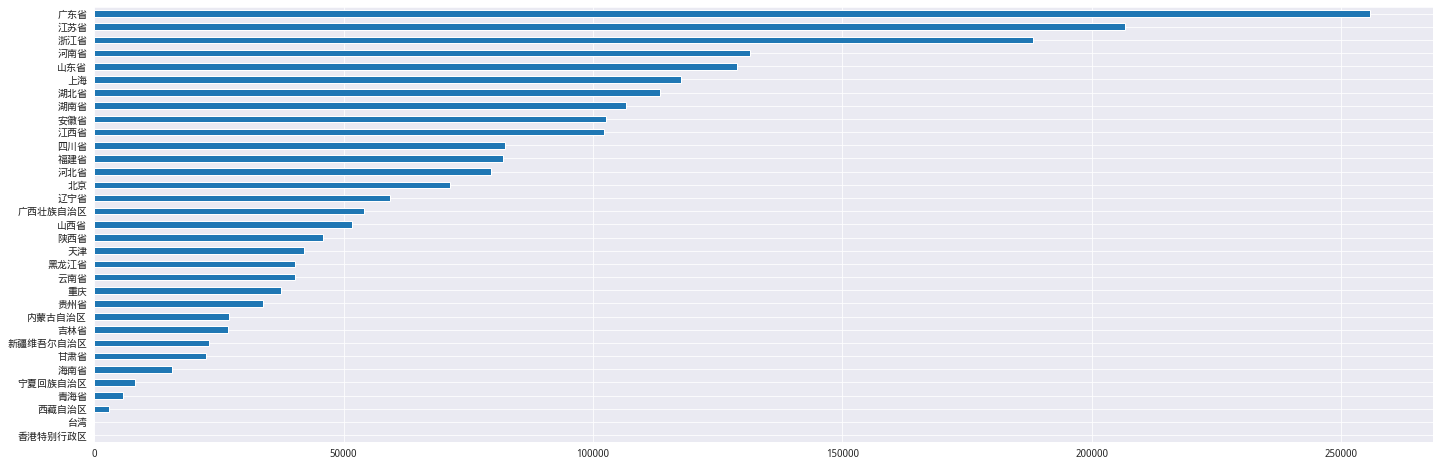

In [29]:

# import matplotlib.pyplot as plt
# %matplotlib inline

raw["customer_province"].value_counts( ascending=True).plot("barh",figsize=(24, 8))


In [31]:
raw["customer_id"].value_counts()#bins=100

1024997    138
1024087     99
1003507     92
1001232     76
2572490     64
          ... 
1189549      1
1193647      1
1230513      1
1236658      1
1001961      1
Name: customer_id, Length: 1585986, dtype: int64

In [34]:
raw["customer_gender"].value_counts() 

0.0    603970
2.0     18468
1.0     13352
Name: customer_gender, dtype: int64

- missing data varies in [customer_gender]  [member_status] [is_member_actived]
- [customer_province] [customer_city] [goods_prices] in some minor lack value
- [member_id] [order_detailed_id] useless drop
- [customer_gender] less data could be used. drop or try

-----

### data statistics: goods
- 'goods_has_discount',
- 'goods_class_id',
- 'goods_price', 
- 'goods_status',
- 'goods_list_time',
- 'goods_delist_time

In [5]:
raw["goods_id"].head(20) #by no means

0      998
1     1953
2     1083
3     1013
4     1628
5     1038
6      998
7     1858
8     1943
9     1038
10     998
11     998
12    1128
13     998
14    1418
15    1043
16    1093
17    1103
18     998
19    1958
Name: goods_id, dtype: int64

In [19]:
raw["goods_class_id"].value_counts() # goods types

998     472943
1038    171277
1333     91748
1413     67783
1488     60263
         ...  
1918         1
6263         1
6248         1
6033         1
6143         1
Name: goods_class_id, Length: 1037, dtype: int64

In [17]:
raw["goods_price"].value_counts(bins=20)

(49.271, 57.887]                 1768095
(40.654, 49.271]                  334153
(57.887, 66.503]                  125641
(32.038, 40.654]                   46347
(23.422, 32.038]                    9441
(6.189, 14.805]                     7680
(83.736, 92.353]                    6440
(-2.427, 6.189]                     4747
(66.503, 75.12]                     1102
(-11.044, -2.427]                   1036
(75.12, 83.736]                      717
(14.805, 23.422]                     603
(-19.66, -11.044]                    269
(-28.277, -19.66]                    100
(-36.893, -28.277]                    40
(-45.509, -36.893]                    18
(-54.126, -45.509]                     4
(-62.742, -54.126]                     1
(-80.14800000000001, -71.358]          1
(-71.358, -62.742]                     0
Name: goods_price, dtype: int64

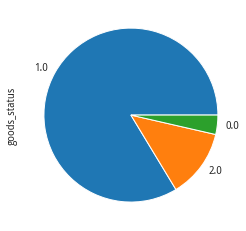

In [21]:
raw['goods_status'].value_counts().plot("pie")

In [24]:
#Todo: weird time problem
raw[['goods_list_time', 'goods_delist_time','order_pay_time']]

,goods_list_time,goods_delist_time,order_pay_time
0,2014-10-25 11:08:07,2014-11-01 11:08:07,2012-11-01 00:10:56
1,2013-08-28 17:27:50,2013-09-01 00:38:17,2013-08-31 23:14:42
2,2014-10-29 18:21:05,2014-11-05 18:21:05,2013-08-31 23:14:42
3,2014-10-25 11:00:00,2014-11-01 11:00:00,2013-08-31 22:06:35
4,2014-10-23 15:35:33,2014-10-30 15:35:33,2013-08-31 21:33:36
...,...,...,...
2306866,2014-10-25 10:14:59,2014-11-01 10:14:59,2013-01-10 19:24:31
2306867,2014-01-10 15:56:40,2014-01-11 12:46:19,2013-01-27 15:00:27
2306868,2014-10-25 11:08:07,2014-11-01 11:08:07,2013-01-27 15:00:27
2306869,2014-10-30 09:31:53,2014-11-06 09:31:53,2012-11-11 00:10:37


## statistics: Order 
- 'order_pay_time',
- 'order_total_num',
- 'order_amount',
- 'order_total_payment',
- 'order_total_discount',
- 'order_status',
- 'order_count', 
- 'order_detail_status',
- 'order_detail_goods_num', 
- 'order_detail_amount',
- 'order_detail_payment',
- 'order_detail_discount', 

##### note: pay time now only used as the training set setions

In [ ]:
data[['goods_id_last', 'goods_status_last', 'goods_price_last', 'goods_has_discount_last',
      'goods_list_time_last', 'goods_delist_time_last']] = raw.groupby('customer_id')['goods_id', 
                                                                                      'goods_status', 
                                                                                      'goods_price',
                                                                                      'goods_has_discount', 
                                                                                      'goods_list_time', 
                                                                                      'goods_delist_time'].last()
data[['order_total_num_last', 'order_amount_last', 'order_total_payment_last', 'order_total_discount_last', 
      'order_pay_time_last',  'order_status_last', 'order_count_last', 'is_customer_rate_last', 
      'order_detail_status_last', 'order_detail_goods_num_last','order_detail_amount_last',
      'order_detail_payment_last','order_detail_discount']] = raw.groupby('customer_id')['order_total_num',
                                                                                          'order_amount',
                                                                                          'order_total_payment', 
                                                                                          'order_total_discount',
                                                                                          'order_pay_time', 
                                                                                          'order_status',
                                                                                          'order_count',
                                                                                          'is_customer_rate',
                                                                                          'order_detail_status',
                                                                                          'order_detail_goods_num',
                                                                                          'order_detail_amount',
                                                                                          'order_detail_payment',
                                                                                          'order_detail_discount'].last()
    
    

In [ ]:
import datetime
import numpy as np

# 对数据进行预处理，各种特征提取
def preprocess(raw, train='train'):
    # 对性别为空的情况，进行0填充
    data = pd.DataFrame(raw.groupby('customer_id')['customer_gender'].last().fillna(0))
    # 添加新的列：商品相关（最后一次行为）
    # 添加商品原始价格（多种统计字段） goods_price： mean, min, max, std
    data[['goods_price_mean', 'goods_price_min', 'goods_price_max', 'goods_price_std']] =         raw.groupby('customer_id')['goods_price'].agg([
            ('goods_price_mean', 'mean'),
            ('goods_price_min', 'min'),
            ('goods_price_max', 'max'),
            ('goods_price_std', 'std')])
   # 订单实付金额（多种统计字段） order_detail_payment： mean, min, max, std
    data[['order_detail_payment_mean', 'order_detail_payment_min', 'order_detail_payment_max', 'order_detail_payment_std']] =         raw.groupby('customer_id')['order_detail_payment'].agg([
            ('order_detail_payment_mean', 'mean'),
            ('order_detail_payment_min', 'min'),
            ('order_detail_payment_max', 'max'),
            ('order_detail_payment_std', 'std')])
    # 用户购买的订单数量
    data['count'] = raw.groupby('customer_id')['order_id'].nunique()
    # 用户购买的商品数量
    #data['goods_count'] = raw.groupby('customer_id')['goods_id'].nunique()
    # order_total_num
    data['order_total_sum'] = raw.groupby('customer_id')['order_total_num'].sum()
    # 用户所在省份
    data['customer_province'] = raw.groupby('customer_id')['customer_province'].last()
    # 用户所在城市
    data['customer_city'] = raw.groupby('customer_id')['customer_city'].last()
    # 用户是否评价 统计结果（平均，总和）
    data[['is_customer_rate_ratio', 'is_customer_rate_sum']] = raw.groupby('customer_id')['is_customer_rate'].agg([
        ('is_customer_rate_ratio', np.mean),
        ('is_customer_rate_sum', np.sum)
    ])
    # 用户购买的goods数量
    data['order_detail_total_num'] = raw.groupby('customer_id')['order_detail_goods_num'].sum()
    # 商品折扣统计属性（sum, mean）
    data[['goods_has_discount_sum', 'goods_has_discount_mean']] = raw.groupby('customer_id')['goods_has_discount'].agg([
        ('goods_has_discount_sum', np.sum),
        ('goods_has_discount_mean', np.mean)
    ])
    # 订单实付金额 统计属性（sum, mean）
    data[['order_total_payment_sum', 'order_total_payment_mean']] = raw.groupby('customer_id')['order_total_payment'].agg([
        ('order_total_payment_sum', np.sum),
        ('order_total_payment_mean', np.mean)
    ])
    # 时间转换
    def time2multi(x):
        t = datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
        # 2013-01-01 的day = 1, weekday = 星期二（2-1=1）
        return pd.Series([t.month, t.day, t.weekday(), t.hour])
    
    # 起始时间 2013-01-01
    t_str = '2013-01-01 00:00:00'
    t = datetime.datetime.strptime(t_str, '%Y-%m-%d %H:%M:%S')
    
    # 商品最新上架时间diff（假设起始时间为2013-01-01 00:00:00）
    data['goods_list_time_diff'] = data['goods_list_time_last'].map(lambda x: (datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S') - t).days/365)
    # 商品最新下架时间diff（假设起始时间为2013-01-01 00:00:00）
    data['goods_delist_time_diff'] = data['goods_delist_time_last'].map(lambda x: (datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S') - t).days/365)
    # 商品展示时间
    data['goods_diff'] = data['goods_delist_time_diff'] - data['goods_list_time_diff']
    
    # 付款时间的尺度
    data[['order_pay_time_last_m', 'order_pay_time_last_d', 'order_pay_time_last_week', 'order_pay_time_last_h']] =         data['order_pay_time_last'].apply(time2multi)
    data['order_pay_time_last_diff'] = data['order_pay_time_last'].map(lambda x: (datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S') - t).days/365)
    return data


# In[46]:


get_ipython().run_cell_magic('time', '', "# 8月之前的做训练集，8月的数据做验证集\nraw['order_pay_time'].max()\ntrain_raw = raw[raw['order_pay_time'] <= '2013-07-31 23:59:59']\n# 提取训练集 各种特征\ntrain_raw = preprocess(train_raw)\ntrain_raw")


# In[47]:


label_raw = set(raw[raw['order_pay_time'] > '2013-07-31 23:59:59']['customer_id'].dropna())
# 如果这个用户在8月份进行了购买 label=1，否则label=0
# 只有用户有order 就会有行为
train_raw['label'] = train_raw.index.map(lambda x:int(x in label_raw))


# In[48]:


get_ipython().run_cell_magic('time', '', '# 用全量的用户特征进行预测，raw 即9月份之前的所有数据\ntest = preprocess(raw)')


# In[50]:


import pickle
with open('test.pkl', 'wb') as file:
    pickle.dump(test, file)
with open('train_raw.pkl', 'wb') as file:
    pickle.dump(train_raw, file)


# In[53]:


# 有些时间戳提取了时间尺度，需要去掉
train_data = train_raw.drop(['goods_list_time_last', 'goods_delist_time_last', 'order_pay_time_last'], axis=1)


# In[57]:


train_data['customer_province'].fillna('0', inplace=True)
train_data['customer_city'].fillna('0', inplace=True)


# In[76]:


from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_data['customer_province'] = le.fit_transform(train_data['customer_province'])
train_data['customer_city'] = le.fit_transform(train_data['customer_city'])
train_data = train_data.drop(['customer_province', 'customer_city'], axis=1)


# In[77]:


# 分类变量
cate1 = ['goods_id_last', 'goods_status_last', 'order_status_last',         'customer_gender', 'order_detail_status_last',         'order_pay_time_last_h', 'order_pay_time_last_week', 'order_pay_time_last_h']


# In[73]:


#train_data[['customer_province', 'customer_city']].isnull().sum()
train_data['customer_province'] = train_data['customer_province'].astype('int64')
train_data['customer_city'] = train_data['customer_city'].astype('int64')


# In[78]:


train_data.info()


# In[79]:


# 训练集切分
from sklearn.model_selection import KFold
import lightgbm as lgb

# 采用CV=5折交叉验证
kf = KFold(n_splits=5,shuffle=True)
y_pred = 0
for train_index , test_index in kf.split(train_data):
    # 设置每一折的 train和test
    X_train, X_valid, y_train, y_valid = train_data.drop('label', axis=1).iloc[train_index], train_data.drop('label', axis=1).iloc[test_index],         np.array(train_data['label'])[train_index], np.array(train_data['label'])[test_index]
    param = {
        'num_leaves': 121,
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'learning_rate': 0.05,
        'metric': 'binary_logloss'
    }
    # 使用lgb进行训练
    trn_data = lgb.Dataset(X_train, y_train)
    val_data = lgb.Dataset(X_valid, y_valid)
    lgbm = lgb.train(param, trn_data, valid_sets=[trn_data, val_data], num_boost_round=10000, early_stopping_rounds=100, verbose_eval=50, categorical_feature=cate1)
    # 计算test的预测结果
    test = test[X_train.columns]
    y_pred = y_pred + lgbm.predict(test)*0.2
    


# In[82]:


pd.DataFrame({
    'column': X_train.columns,
    'importance':lgbm.feature_importance()
}).sort_values(by='importance')


# In[88]:


def f(x):
    """
    if x<0.1:
        return 0.1
    if x>0.9:
        return 0.9
    """
    return round(x*1000)/1000

test['result'] = y_pred
test['result'] = test['result'].map(f)
result = pd.DataFrame(test['result'])
result.to_csv('submission5.csv')
result


# In[96]:


temp = result.reset_index()
temp['result'] = temp['result'].map(lambda x: 0 if x<0.5 else 1)
temp
temp = temp.sort_values(by='customer_id')
temp.to_csv('./test2.csv', index=False)

### Popularity  Recommadation
- Count 
- Ratio 
- Possibility
-----
- time issues
- space and location
- social phycologist
- single or group
---- 
#### Engine Initialization
- none-poplularity recc
- algorithms
- representations and indentity
- diversity and unifiations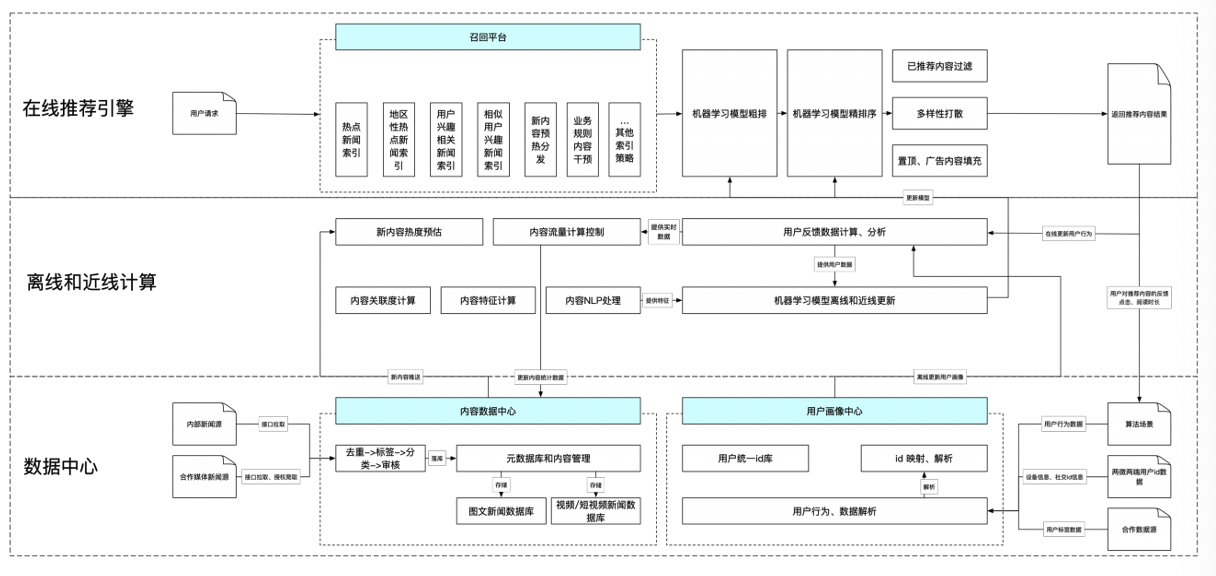

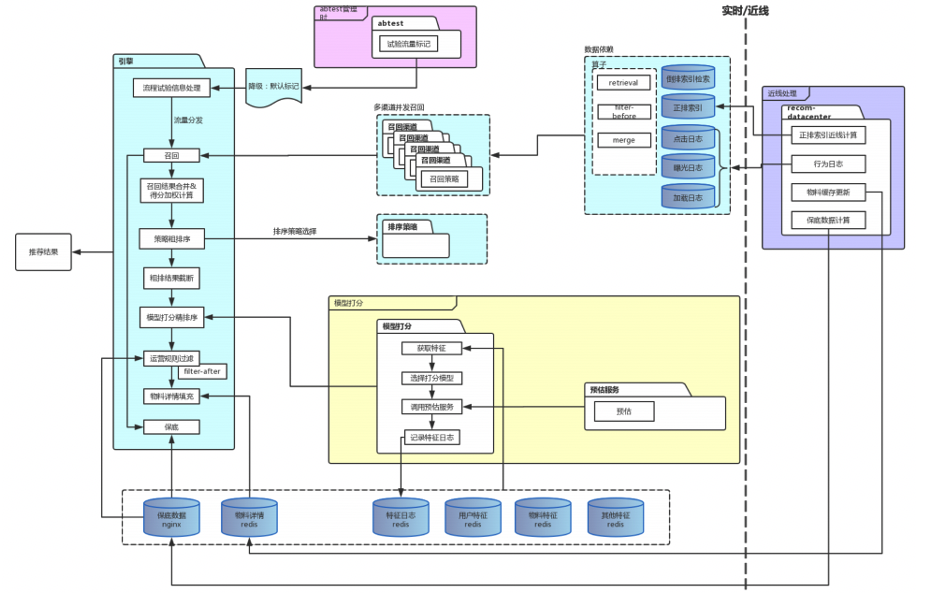